In [1]:
!pip install turicreate==5.4
# The wrong version of MXNET will be installed
!pip uninstall -y mxnet
# Install CUDA10-compatible version of mxnet 
!pip install mxnet-cu100==1.4.0.post0

     |████████████████████████████████| 87.4MB 119kB/s 
     |████████████████████████████████| 23.8MB 376kB/s 
     |████████████████████████████████| 2.7MB 24.3MB/s 
     |████████████████████████████████| 327kB 42.9MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320847 sha256=be5cd8cc1c24dc2fca85619975c860441f3ff58cc89fe132b97a40d4073fcbd9
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built resampy
ERROR: mxnet 1.1.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.17.4 which is incompatible.
ERROR: mxnet 1.1.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.21.0 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: resampy 0.2.2
    Uninstalling resampy-0.2.2:
      Successfully uninstalled resampy-0.2.2
U

In [1]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

Google Drive already mounted


In [2]:
import mxnet as mx
import turicreate as tc

         To fix this, please install the currently recommended version:

             pip uninstall -y mxnet && pip install mxnet==1.1.0

         If you want to use a CUDA GPU, then change 'mxnet' to 'mxnet-cu90' (adjust 'cu90' depending on your CUDA version):



In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.stats import boxcox

# Data loading

In [164]:
base_db = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/ML_Project/base_db.csv").drop(columns="Unnamed: 0")
base_db.head()

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
0,10108642,S,48.0,T,46.900000,Actinopterygii,Cypriniformes,Cyprinidae,Carassius,auratus,NR,1.93 (0.82-4.15) G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
1,88302,S,6.0,A,2.920000,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,FI,NR,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
2,1397940,S,96.0,A,0.000063,Actinopterygii,Perciformes,Centrarchidae,Micropterus,salmoides,NR,20.5G,Fish
3,25474413,S,96.0,A,0.012000,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NR,1G,"Fish,Standard Test Species"
4,540727,F,36.0,T,144.000000,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,JV,0.62 G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."


In [0]:
base_db96 = base_db[base_db.obs_duration_mean==96]

In [54]:
X_original = base_db96.copy()
X_original = X_original[["test_cas", "species", "conc1_mean", "exposure_type", "conc1_type"]].reset_index(drop=True)
X_original.head()

,test_cas,species,conc1_mean,exposure_type,conc1_type
0,1397940,salmoides,0.000063,S,A
1,25474413,macrochirus,0.012000,S,A
2,72435,fontinalis,0.010000,S,A
3,2921882,macrochirus,0.002400,S,A
4,7758987,tshawytscha,0.058000,S,T


In [55]:
X_side_species = base_db96.copy()
X_side_species = X_side_species[["species", "class", "tax_order", "family", "genus"]]
X_side_species = X_side_species.drop_duplicates(subset="species").reset_index(drop=True)
X_side_species.head()

,species,class,tax_order,family,genus
0,salmoides,Actinopterygii,Perciformes,Centrarchidae,Micropterus
1,macrochirus,Actinopterygii,Perciformes,Centrarchidae,Lepomis
2,fontinalis,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus
3,tshawytscha,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus
4,mykiss,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus


In [56]:
base_db_smiles = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/ML_Project/base_db_smiles.csv")
base_db_smiles.test_cas = base_db_smiles.test_cas.apply(lambda x: x.replace("-", "")).astype(int)
base_db_smiles.head()

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group,smiles,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
0,10108642,S,48.0,T,46.900,Actinopterygii,Cypriniformes,Cyprinidae,Carassius,auratus,NR,1.93 (0.82-4.15) G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc...",[Cl-].[Cl-].[Cd++],3,3,0,0,0.0,0.0,183.318,0.666667,-5.9945
1,10108642,S,24.0,T,200.000,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Fundulus,heteroclitus,NR,"49.6 MM, 1.0 G","Fish,Standard Test Species",[Cl-].[Cl-].[Cd++],3,3,0,0,0.0,0.0,183.318,0.666667,-5.9945
2,10108642,F,96.0,T,0.001,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,PA,"6.96 G, 8.6 CM","Fish,Standard Test Species,U.S. Exotic/Nuisanc...",[Cl-].[Cl-].[Cd++],3,3,0,0,0.0,0.0,183.318,0.666667,-5.9945
3,10108642,S,96.0,T,15.900,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Cyprinodon,variegatus,NR,"25.8 MM, 0.70 G","Fish,Standard Test Species",[Cl-].[Cl-].[Cd++],3,3,0,0,0.0,0.0,183.318,0.666667,-5.9945
4,10108642,F,694.0,T,0.030,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,JV,0.193 G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc...",[Cl-].[Cl-].[Cd++],3,3,0,0,0.0,0.0,183.318,0.666667,-5.9945


In [0]:
base_db_smiles96 = base_db_smiles[base_db_smiles.obs_duration_mean==96]

In [58]:
X_side_cas = base_db_smiles96.copy()
X_side_cas = X_side_cas[["test_cas", "atom_number", "alone_atom_number", "tripleBond", "doubleBond", "bonds_number", "ring_numer"]]
X_side_cas = X_side_cas.drop_duplicates(subset="test_cas").reset_index(drop=True)
X_side_cas = X_side_cas.dropna()
X_side_cas.head()

,test_cas,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer
0,10108642,3,3,0,0,0.0,0.0
1,88302,8,2,0,1,14.0,1.0
2,1397940,38,5,0,5,40.0,2.0
3,540727,4,2,1,0,2.0,0.0
4,72435,9,0,0,0,22.0,2.0


In [0]:
X_original = X_original.groupby(by=["test_cas", "species", "conc1_type", "exposure_type"]).agg("median").reset_index()
X_original["score"] = 1/X_original.conc1_mean

In [60]:
X_original

,test_cas,species,conc1_type,exposure_type,conc1_mean,score
0,50000,affinis,A,R,90.000000,0.011111
1,50000,affinis,A,S,133.550000,0.007488
2,50000,carolinus,F,S,71.600000,0.013966
3,50000,chanos,F,S,232.000000,0.004310
4,50000,fasciata,F,R,115.000000,0.008696
...,...,...,...,...,...,...
11156,1161016825,rerio,F,R,0.000616,1623.376623
11157,1161016847,rerio,F,R,0.001120,892.857143
11158,1161016869,rerio,F,R,0.001641,609.384522
11159,1315501188,reticulata,A,S,0.021350,46.838407


In [0]:
enc_species = OrdinalEncoder(dtype=int)
enc_species.fit(X_original.species.values.reshape(-1, 1))
enc_cas = OrdinalEncoder(dtype=int)
enc_cas.fit(X_original.test_cas.values.reshape(-1,1))

X_original["species"] = enc_species.transform(X_original.species.values.reshape(-1,1))
X_original["test_cas"] = enc_cas.transform(X_original.test_cas.values.reshape(-1,1))
X_side_species["species"] = enc_species.transform(X_side_species.species.values.reshape(-1,1))
X_side_cas["test_cas"] = enc_cas.transform(X_side_cas.test_cas.values.reshape(-1,1))

X_fact = X_original.drop(columns=["conc1_mean"]).reset_index(drop=True)

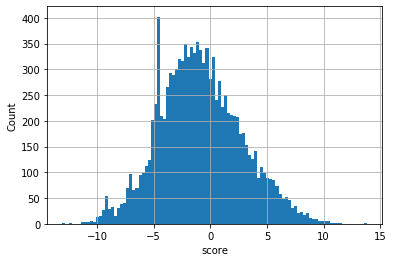

In [119]:
X_fact_scored = X_fact.copy()
X_fact_scored.score = X_fact_scored.score.apply(lambda x: np.log(x))

# plotting the distribution of conc inside this case
X_fact_scored.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

# Basic tests

In [0]:
minmax = MinMaxScaler((1, 10))
minmax.fit(X_fact_scored[["score"]])
X_fact_scored[["score"]] = minmax.transform(X_fact_scored[["score"]])

In [121]:
X = tc.SFrame(X_fact_scored)
X

test_cas,species,conc1_type,exposure_type,score
0,3,A,R,3.8642835866570193
0,3,A,S,3.7320685734496584
0,71,F,S,3.9409040271072886
0,82,F,S,3.5470584567157486
0,131,F,R,3.7821664371731405
0,167,F,R,3.8158482108284737
0,188,A,S,4.336227075933329
0,220,F,S,4.62287915355913
0,267,F,S,3.695395497824532
0,278,F,S,3.66428473194256


In [122]:
X_cas = tc.SFrame(X_side_cas)
X_cas

test_cas,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer
1644,3,3,0,0,0.0,0.0
230,8,2,0,1,14.0,1.0
1102,38,5,0,5,40.0,2.0
823,4,2,1,0,2.0,0.0
104,9,0,0,0,22.0,2.0
1288,12,1,0,1,18.0,1.0
1853,24,0,0,4,23.0,0.0
1527,7,5,0,2,4.0,0.0
1534,6,4,0,2,4.0,0.0
225,6,0,0,0,12.0,1.0


In [123]:
X_species = tc.SFrame(X_side_species)
X_species

species,class,tax_order,family,genus
342,Actinopterygii,Perciformes,Centrarchidae,Micropterus
220,Actinopterygii,Perciformes,Centrarchidae,Lepomis
141,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus
395,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus
267,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus
311,Actinopterygii,Acipenseriformes,Acipenseridae,Scaphirhynchus
319,Actinopterygii,Siluriformes,Ictaluridae,Ictalurus
204,Actinopterygii,Beloniformes,Adrianichthyidae,Oryzias
317,Actinopterygii,Perciformes,Channidae,Channa
316,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales


In [0]:
X_train, X_test = tc.recommender.util.random_split_by_user(X, 'test_cas', 'species', max_num_users=2000, item_test_proportion=0.3)

In [125]:
X_train

test_cas,species,conc1_type,exposure_type,score
0,3,A,R,3.8642835866570193
0,3,A,S,3.7320685734496584
0,71,F,S,3.9409040271072886
0,131,F,R,3.7821664371731405
0,188,A,S,4.336227075933329
0,220,F,S,4.62287915355913
0,278,F,S,3.66428473194256
0,316,A,S,4.276419883067372
0,330,A,S,4.1276767956877105
0,336,F,S,3.429373314787725


In [126]:
X_test

test_cas,species,conc1_type,exposure_type,score
0,82,F,S,3.5470584567157486
0,167,F,R,3.8158482108284737
0,267,F,S,3.695395497824532
0,316,A,F,4.302916263663142
0,319,F,S,3.9532953677639986
0,336,A,S,3.6838491393281543
1,316,A,F,3.3007136544365427
4,3,A,F,7.953373995130322
4,3,A,S,6.624011018295802
4,3,F,S,6.581749758197885


In [127]:
model = tc.recommender.factorization_recommender.create(X_train, 'test_cas', 'species', target='score', user_data=X_cas, solver="sgd", item_data=X_species, max_iterations=10000)

Preparing data set.

Data has 8685 observations with 2523 users and 416 items.

Data prepared in: 0.032324s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 10000    |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 8685 / 8685 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.57143           | Not Viable                               |

| 1       | 0.892857          | Not Viable                               |

| 2       | 0.223214          | Not Viable                               |

| 3       | 0.0558036         | Not Viable                               |

| 4       | 0.0139509         | Not Viable                               |

| 5       | 0.00348772        | Not Viable                               |

| 6       | 0.000871931       | 1.04928                                  |

| 7       | 0.000435965       | 1.10115                                  |

| 8       | 0.000217983       | 1.15024                                  |

| 9       | 0.000108991       | 1.18949                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.000871931       | 1.04928                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 1.46904           | 1.21204               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 25.833ms     | 1.13455           | 1.06515               | 0.000871931 |

| 2       | 56.092ms     | 1.0702            | 1.03451               | 0.000518453 |

| 3       | 73.152ms     | 1.0577            | 1.02844               | 0.000382508 |

| 4       | 89.805ms     | 1.03494           | 1.01732               | 0.000308274 |

| 5       | 107.509ms    | 1.03183           | 1.01579               | 0.000260768 |

| 10      | 182.345ms    | 0.991545          | 0.995764              | 0.000155054 |

| 50      | 762.854ms    | 0.913869          | 0.955965              | 1.63949e-05 |

| 100     | 1.52s        | 0.896167          | 0.946661              | 9.74848e-06 |

| 250     | 3.62s        | 0.874872          | 0.935346              | 2.91548e-06 |

| 500     | 7.12s        | 0.86325           | 0.929113              | 1.03078e-06 |

| 750     | 10.65s       | 0.858184          | 0.926382              | 4.52193e-07 |

| 791     | 11.23s       | 0.857942          | 0.926252              | 1.53618e-07 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.857935

Final training RMSE: 0.926248

In [128]:
model.evaluate_rmse(X_test, 'score')['rmse_overall']

0.9529245520397175

In [129]:
X_test_predict = model.predict(X_test)
X_test_predict

dtype: float
Rows: 2476
[4.386297134010448, 4.4601862971027515, 4.203107199804236, 4.19705263347808, 4.204879064723485, 4.495036009790994, 4.989181698944432, 5.8450310357353255, 5.545914634282405, 5.508500714872377, 6.549766543487373, 6.168651797778318, 6.272992307806441, 6.522608578967799, 6.391790329348248, 6.213985333690823, 6.374517662804998, 6.480435382387975, 5.623745136689274, 6.292737821232174, 5.934601095089044, 5.896942296617078, 6.279717489300844, 6.283628199924885, 6.236419621780976, 6.060721986387386, 6.8172357050849195, 6.331525936561399, 6.032338493364102, 6.326051243226709, 6.014989822523227, 6.170238615590812, 6.524098890917764, 5.836799545212295, 5.824275664787444, 5.992157459439647, 5.90044024392281, 6.2520585971929785, 6.407208073075332, 6.337937512397809, 6.351874017239958, 6.481309907942511, 5.616103499992819, 5.318576848312292, 5.47905097855582, 4.706698132441275, 4.491838306431205, 4.340006822433466, 4.797201850987008, 4.323449277723526, 5.972657434825585, 6.016

In [130]:
X_test_score = X_test.select_column("score")
X_test_score

dtype: float
Rows: 2476
[3.5470584567157486, 3.8158482108284737, 3.695395497824532, 4.302916263663142, 3.9532953677639986, 3.6838491393281543, 3.3007136544365427, 7.953373995130322, 6.624011018295802, 6.581749758197885, 7.006431268970676, 6.924697639384205, 7.462144341029601, 7.760624363481509, 6.850634968813264, 7.256751526135126, 6.91449366495341, 7.317830085209334, 6.508487871260858, 7.5081073470107285, 7.108735524431648, 7.111740070076122, 6.182156444970209, 7.685870248715058, 6.9611470972518115, 6.654185492820295, 8.137146108966842, 7.140067183505004, 6.767676249837257, 7.353126341959533, 7.064001894486313, 7.085622595544268, 6.9388051804281154, 6.699469664539159, 6.079258385051617, 6.727019805233679, 6.425850931767662, 7.2214552693849265, 7.550037574874398, 6.217871195958214, 6.8676727722197315, 7.243075970442883, 4.808655426693343, 4.890980588971111, 4.791627934927907, 4.673447179116967, 4.650890274579301, 4.750395997246812, 5.333774867243287, 4.336227075933329, 4.23232375016274

In [131]:
tc.evaluation.rmse(X_test_score, X_test_predict)

0.9529245520397186

In [0]:
X_test_predict_conc = minmax.inverse_transform(X_test_predict.to_numpy().reshape(-1, 1))
X_test_predict_conc = np.exp(X_test_predict_conc)    
X_test_predict_conc = 1/X_test_predict_conc

In [0]:
X_test_conc = minmax.inverse_transform(X_test_score.to_numpy().reshape(-1, 1))
X_test_conc = np.exp(X_test_conc)    
X_test_conc = 1/X_test_conc

In [134]:
sqrt(mean_squared_error(X_test_conc, X_test_predict_conc))

3164.8372757090356

In [135]:
X_test_predict_conc

array([[18.9457881 ],
       [15.1958141 ],
       [32.73385191],
       ...,
       [ 6.58261567],
       [ 7.23738743],
       [ 2.03138508]])

In [136]:
X_test_conc

array([[2.320e+02],
       [1.040e+02],
       [1.490e+02],
       ...,
       [7.700e+00],
       [2.135e-02],
       [2.500e+03]])

# Implementing CV

In [0]:
X_train_original, X_test_original, X_train_scored, X_test_scored = train_test_split(X_original, X_fact_scored, test_size=0.33)

In [0]:
X_train_original = X_train_original.reset_index(drop=True)
X_test_original = X_test_original.reset_index(drop=True)
X_train_scored = X_train_scored.reset_index(drop=True)
X_test_scored = X_test_scored.reset_index(drop=True)

In [152]:
factors = range(10, 100, 20)
regularizs = np.logspace(-12, 0, 10)
lin_regularizs = np.logspace(-12, 0, 10)
best_rmse, best_scale, best_params = cv_scale(X_train_original, X_train_scored, X_cas, X_species, factors, regularizs, lin_regularizs, max_scale=15, min_scale=5, step_size= 1, params_sample=True)
pickle.dump(best_rmse, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_rmse_categories.pkl", "wb" ) )
pickle.dump(best_scale, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_scale_categories.pkl", "wb" ) )
pickle.dump(best_params, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_params_categories.pkl", "wb" ) )

New best param combination found! Rmse:0.4173155655640217, num_factors:10, regularizer:0.0021544346900318778, lin_reg:1e-08
New best param combination found! Rmse:0.4124945399860885, num_factors:10, regularizer:0.0021544346900318778, lin_reg:1e-08
New best param combination found! Rmse:0.4120521985272447, num_factors:30, regularizer:0.046415888336127725, lin_reg:4.6415888336127727e-10
New best param combination found! Rmse:0.4119306378293592, num_factors:30, regularizer:0.046415888336127725, lin_reg:4.6415888336127727e-10
New best param combination found! Rmse:0.40866418489946854, num_factors:30, regularizer:4.6415888336127727e-10, lin_reg:4.6415888336127727e-10
New best param combination found! Rmse:0.4695994354769675, num_factors:30, regularizer:1e-08, lin_reg:0.046415888336127725
New best param combination found! Rmse:0.40180448973074395, num_factors:30, regularizer:1e-08, lin_reg:1e-08
New best param combination found! Rmse:0.3933319396338277, num_factors:30, regularizer:1e-08, lin

KeyboardInterrupt: ignored

In [0]:
def cv_scale(X_real, X_real_scored,  X_cas, X_species, list_factors, list_regulariz, list_lin_regulariz, min_scale = 10, max_scale = 50, step_size=10, cv = 3, params_sample=True):
    best_scale = 0
    best_rmse = np.inf
    best_params = []
    best_model = None
    cas = X_real.test_cas.max()
    species = X_real.species.max()
    
    for scale in range(min_scale, max_scale+1, step_size):
        
        X_real_score = X_real_scored.copy()

        # MinMax scale score
        minmax = MinMaxScaler((1, scale))
        minmax.fit(X_real_score[["score"]])
        X_real_score[["score"]] = minmax.transform(X_real_score[["score"]])
        
        kf = KFold(n_splits=cv, shuffle=True)
        
        rmses = []
        params = []
        
        for train_index, test_index in kf.split(X_real_score):
            model, param = cv_fact(X_real_score.loc[train_index].reset_index(drop=True), X_cas, X_species, factors=list_factors, regularizs=list_regulariz, lin_regulars = list_lin_regulariz, cv=cv, params_samples=params_sample)
            params.append(param)

            # rmse
            X_test = tc.SFrame(X_real_score.loc[test_index])
            rmses.append(model.evaluate_rmse(X_test, 'score')['rmse_overall'])
        
        avg_rmse = np.mean(rmses)
        print("Scale: {}, avg_rmse: {}".format(scale, avg_rmse))
        if (avg_rmse < best_rmse):
            print("New best scale found:", scale)
            print("New best rmse", avg_rmse)
            best_rmse = avg_rmse
            best_scale = scale
            best_params = params
          
    return best_rmse, best_scale, best_params

In [0]:
def cv_fact(X_train_scored, X_cas, X_species, factors, regularizs, lin_regulars,  cv = 3, verbose=True, params_samples = True, num_samples = 5):
  best_factor = 0
  best_regulariz = 0
  best_lin_regulariz = 0
  best_rmse = np.inf
  best_model = None

  if params_samples:
    factors = np.random.choice(factors, num_samples)
    regularizs = np.random.choice(regularizs, num_samples)
    lin_regulars = np.random.choice(lin_regulars, num_samples)
    
  for factor in factors:
    for regulariz in regularizs:
      for lin_regular in lin_regulars:
        rmses = []
        kf2 = KFold(n_splits=cv, shuffle=True)

        for train_ind, test_ind in kf2.split(X_train_scored):
          train = tc.SFrame(X_train_scored.loc[train_ind])
          test = tc.SFrame(X_train_scored.loc[test_ind])

          model = tc.recommender.factorization_recommender.create(train, 'test_cas', 'species', target='score', max_iterations=100, \
                                                                  num_factors = factor, regularization=regulariz, linear_regularization=lin_regular, solver="sgd", verbose=False, user_data=X_cas, item_data=X_species)
          rmses.append(model.evaluate_rmse(test, 'score')['rmse_overall'])

        rmses_avg = np.mean(rmses)
        if (rmses_avg < best_rmse):
          if verbose:
            print("New best param combination found! Rmse:{}, num_factors:{}, regularizer:{}, lin_reg:{}".format(rmses_avg, factor, regulariz, lin_regular))     
          best_rmse = rmses_avg
          best_lin_regulariz = lin_regular
          best_regulariz = regulariz
          best_factor = factor
          best_model = tc.recommender.factorization_recommender.create(tc.SFrame(X_train_scored), 'test_cas', 'species', target='score', max_iterations=100, \
                                                                       num_factors = best_factor, regularization=best_regulariz, linear_regularization=best_lin_regulariz, solver="sgd", verbose=False)
    
    return best_model, {"best_lin_regulariz": best_lin_regulariz, "best_regulariz": best_regulariz, "best_factor":best_factor}


In [153]:
X_test_sc = X_test_scored.copy()
X_train_sc = X_train_scored.copy()

minmax = MinMaxScaler((1, 5))
minmax.fit(X_train_sc[["score"]])
X_train_sc[["score"]] = minmax.transform(X_train_sc[["score"]])

minmax = MinMaxScaler((1, 5))
minmax.fit(X_test_sc[["score"]])
X_test_sc[["score"]] = minmax.transform(X_test_sc[["score"]])

model_test = tc.recommender.factorization_recommender.create(tc.SFrame(X_train_sc), 'test_cas', 'species', target='score', max_iterations=10000, \
                                                                       num_factors = 30, regularization=1e-08, linear_regularization=0.0001, solver="sgd", verbose=True, user_data=X_cas, item_data=X_species)

Preparing data set.

Data has 7477 observations with 2514 users and 416 items.

Data prepared in: 0.029821s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 30       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 10000    |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 7477 / 7477 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.57143           | Not Viable                               |

| 1       | 0.892857          | Not Viable                               |

| 2       | 0.223214          | Not Viable                               |

| 3       | 0.0558036         | Not Viable                               |

| 4       | 0.0139509         | Not Viable                               |

| 5       | 0.00348772        | 0.186843                                 |

| 6       | 0.00174386        | 0.242755                                 |

| 7       | 0.000871931       | 0.205893                                 |

| 8       | 0.000435965       | 0.218186                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00348772        | 0.186843                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 0.290825          | 0.539282              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 35.835ms     | 0.445399          | 0.667303              | 0.00348772  |

| 2       | 60.353ms     | 0.20351           | 0.450916              | 0.00207381  |

| 3       | 85.519ms     | 0.179757          | 0.423679              | 0.00153003  |

| 4       | 109.575ms    | 0.183785          | 0.428353              | 0.00103691  |

| 5       | 133.61ms     | 0.173808          | 0.416493              | 0.000737564 |

| 10      | 244.421ms    | 0.18765           | 0.432659              | 0.000184391 |

| 45      | 1.04s        | 0.20902           | 0.456626              | 6.19916e-08 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.209018

Final training RMSE: 0.456624

In [154]:
model_test.evaluate_rmse(tc.SFrame(X_test_sc), 'score')['rmse_overall']

0.6278645051011432

In [155]:
X_test_predict = model_test.predict(tc.SFrame(X_test_sc))
X_test_predict

dtype: float
Rows: 3684
[2.6905984330766164, 2.8601114113057857, 2.7918940043464318, 2.319329705265121, 2.1357769771548556, 2.9025544035440243, 2.8188326943521216, 2.580017042055787, 2.5909696382122362, 2.9335697900759845, 2.523565889221801, 2.845079943165595, 2.5866953783216884, 2.081084590994211, 2.716616410663218, 2.7736398807991667, 3.036613431305404, 3.333460000274619, 2.9961206008928953, 2.7298358638571627, 3.0550811285874757, 2.511981474943029, 2.7221852539600913, 3.238303569120248, 2.7301009871328543, 2.923315692726642, 2.7569195161637063, 2.796924519987538, 2.86819250929887, 3.007810316907465, 2.7881861526492084, 2.9953600396650955, 2.935046262444232, 2.513267041098634, 2.8995661003775433, 2.6146422967021703, 2.8465337900950543, 2.6809870849932502, 1.9744341046688465, 2.844657855622829, 2.5705266034949616, 2.6168205294899343, 2.8007978712616146, 2.617296583326835, 2.874665016507018, 2.7793630211918665, 3.280374578335099, 2.6219919608286104, 2.603344205592802, 2.680015717029882

In [0]:
X_test_predict_conc = minmax.inverse_transform(X_test_predict.to_numpy().reshape(-1, 1))
X_test_predict_conc = np.exp(X_test_predict_conc)    
X_test_predict_conc = 1/X_test_predict_conc

In [157]:
sqrt(mean_squared_error(X_test_original.conc1_mean.values, X_test_predict_conc))

2465.849261794647

In [0]:
def compute_absolute_intervals(X_real, X_pred_conc, pred_target="conc1_mean"):
    X_intervals = X_real.copy()
    intervals = np.zeros(X_intervals.index.size)
    prediction = np.zeros(X_intervals.index.size)
    
    for i, row in X_intervals.iterrows():
        prediction[i] =  X_pred_conc[i]
        intervals[i] = np.abs(row[pred_target] - prediction[i])
        
    X_intervals["prediction"] = prediction   
    X_intervals["intervals"] = intervals
    return X_intervals

In [159]:
X_intervals = compute_absolute_intervals(X_test_original, X_test_predict_conc)
X_intervals.head()

,test_cas,species,conc1_type,exposure_type,conc1_mean,score,prediction,intervals
0,148,404,F,S,14400.00,0.000069,0.005742,14399.994258
1,1941,220,A,S,0.13,7.692308,0.004025,0.125975
2,1002,244,F,S,3.00,0.333333,0.004644,2.995356
3,1546,95,T,F,55.00,0.018182,0.012504,54.987496
4,633,316,F,S,465.00,0.002151,0.018370,464.981630


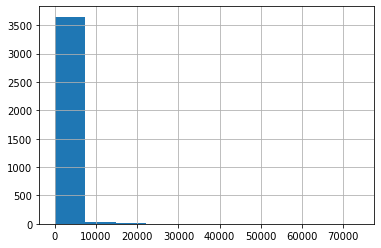

In [160]:
X_intervals.intervals.hist()

In [161]:
X_intervals[X_intervals.intervals > 1000]

,test_cas,species,conc1_type,exposure_type,conc1_mean,score,prediction,intervals
0,148,404,F,S,14400.00,0.000069,0.005742,14399.994258
58,1540,237,T,R,1100.00,0.000909,0.006346,1099.993654
139,357,7,F,S,10000.00,0.000100,0.008834,9999.991166
171,397,7,A,S,10000.00,0.000100,0.006816,9999.993184
184,1499,208,T,R,6136.97,0.000163,0.005652,6136.964348
...,...,...,...,...,...,...,...,...
3563,810,220,F,AQUA,3433.00,0.000291,0.002500,3432.997500
3634,1997,267,F,R,2300.00,0.000435,0.018229,2299.981771
3650,496,3,F,S,1400.00,0.000714,0.010398,1399.989602
3660,663,220,A,S,1115.00,0.000897,0.017535,1114.982465


In [162]:
X_intervals.test_cas = enc_cas.inverse_transform(X_intervals.test_cas.values.reshape(-1,1))
X_intervals.species = enc_species.inverse_transform(X_intervals.species.values.reshape(-1,1))
X_intervals

,test_cas,species,conc1_type,exposure_type,conc1_mean,score,prediction,intervals
0,77996,variegatus,F,S,14400.0000,0.000069,0.005742,14399.994258
1,27554263,macrochirus,A,S,0.1300,7.692308,0.004025,0.125975
2,886500,melas,F,S,3.0000,0.333333,0.004644,2.995356
3,7778509,crysoleucas,T,F,55.0000,0.018182,0.012504,54.987496
4,129679,promelas,F,S,465.0000,0.002151,0.018370,464.981630
...,...,...,...,...,...,...,...,...
3679,1420048,reticulata,A,R,0.3900,2.564103,0.003351,0.386649
3680,101202,mykiss,F,S,0.1200,8.333333,0.003644,0.116356
3681,543908,mykiss,T,S,0.0062,161.290323,0.007494,0.001294
3682,154592208,melastigma,T,R,0.0082,121.951220,0.004241,0.003959


In [167]:
base_db96[(base_db96.test_cas==77996) & (base_db96.species=="variegatus")]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
17013,77996,S,96.0,F,14400.0,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Cyprinodon,variegatus,NR,NR,"Fish,Standard Test Species"
